In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut

from sampler import sample_from_logreg

from sklearn.gaussian_process.kernels import RBF

import numpy as np
import matplotlib.pyplot as plt

from cv_svm import SVM_smooth
from kernel_svm import SVM_smooth_kernel

#import matplotlib
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})

In [2]:
#X, y = load_breast_cancer(return_X_y=True)
#X, y = make_classification(n_samples=250, n_features=50)
X, _, y = sample_from_logreg(n=250, p=20, seed=120)
n = X.shape[0]
p = X.shape[1]
y[np.where(y == 0)] = -1

In [3]:
X_scaled = StandardScaler().fit_transform(X)
#X_scaled = X
print(X_scaled.shape)

(250, 20)


In [4]:
clf = SVC(kernel='linear')
clf.fit(X_scaled, y)
sk_coef_og = clf.coef_.flatten()
sk_coef = clf.coef_/np.linalg.norm(clf.coef_)
print(clf.coef_)
print(clf.intercept_)

[[ 1.44119178e+00 -2.29122060e-01 -4.73133921e-01 -5.71197691e-01
  -9.23568038e-02 -4.16302288e-01  2.29394113e-01 -2.91213658e-02
  -1.85803923e-01  1.53175947e-01  2.37632445e-01  1.26117844e-01
   1.51192806e-01 -1.06962035e-03  1.36621515e-02  4.48711746e-01
   1.74007771e+00  2.70215171e-02 -2.03117321e+00  3.15806682e-02]]
[-0.02560786]


In [5]:
y_pred = clf.predict(X_scaled)
accuracy_score(y, y_pred)

0.88

In [6]:
#sigma = 1e-5
#lbd = 1e-4
sigma = 5e-1
lbd = 1

In [7]:
# calculate maximum bound
from sklearn.metrics import pairwise_distances
m_max = np.min(pairwise_distances(X))**2
print(m_max)

C = np.linalg.norm(X.T @ X)/(n - 1)

max_bound = 1 + C/(lbd * sigma) *\
            1/(2 * np.sqrt(1 + (m_max/sigma)**2)**3)
print(max_bound)

# what lambda do we have to pick?
b = 1e10
lbd_pick = C/((b - 1) * sigma) *\
            1/(2 * np.sqrt(1 + (m_max/sigma)**2)**3)
lbd_pick

0.0
5.625677341209748


4.6256773416723155e-10

In [8]:
clf = SVM_smooth(sigma=sigma, lbd=lbd)
clf.fit(X_scaled, y, thresh=1e-7, n_iter=50, eta=0.5/n,
        approx_cv=True, cv=True, log_iter=True, log_iacv=True,
        save_cond_nums=True, save_err_approx=True, save_err_cv=True,
        warm_start=0, normalise=False, adjust_factor=True,
        save_hessian_norms=True)
#clf = SVM_smooth_kernel(sigma=sigma, lbd=lbd, kernel=RBF(3.5))
#clf.fit(X_scaled, y, n_iter=2500, eta=0.5/n, approx_cv=True, cv=True, log_iacv=True, save_err_approx=True, save_err_cv=True)

#print(f"grad {np.linalg.norm(clf.nabla_fgd_(clf.weights_, X_scaled, y, clf.sigma_, clf.lbd_))}")
#coef = clf.weights_/np.linalg.norm(clf.weights_)
#print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

coef = clf.weights_/np.linalg.norm(clf.weights_)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

y_pred = clf.predict(X_scaled)
accuracy_score(y, y_pred)

iter 0 | grad 0.67138 | objective 1.05879 | NS: 0.00133780 | IACV: 0.00000537 | baseline: 0.00003349
iter 1 | grad 0.66992 | objective 1.05856 | NS: 0.00267268 | IACV: 0.00001073 | baseline: 0.00006690
iter 2 | grad 0.66846 | objective 1.05833 | NS: 0.00400465 | IACV: 0.00001608 | baseline: 0.00010024
iter 3 | grad 0.66700 | objective 1.05810 | NS: 0.00533372 | IACV: 0.00002142 | baseline: 0.00013350
iter 4 | grad 0.66554 | objective 1.05787 | NS: 0.00665988 | IACV: 0.00002674 | baseline: 0.00016669
iter 5 | grad 0.66409 | objective 1.05765 | NS: 0.00798315 | IACV: 0.00003205 | baseline: 0.00019980
iter 6 | grad 0.66264 | objective 1.05742 | NS: 0.00930353 | IACV: 0.00003735 | baseline: 0.00023284
iter 7 | grad 0.66119 | objective 1.05720 | NS: 0.01062103 | IACV: 0.00004263 | baseline: 0.00026580
iter 8 | grad 0.65974 | objective 1.05697 | NS: 0.01193564 | IACV: 0.00004790 | baseline: 0.00029868
iter 9 | grad 0.65830 | objective 1.05675 | NS: 0.01324737 | IACV: 0.00005316 | baseline: 0

0.844

In [9]:
iacv_coef = normalize(clf.approx_cv_obj.iterates, axis=1)
true_coef = normalize(clf.true_cv_obj.iterates, axis=1)
print(np.mean(np.linalg.norm(iacv_coef - true_coef, 2, axis=1)))
print(np.mean(np.linalg.norm(coef - true_coef, 2, axis=1)))

5.794877341932314e-05
0.024332993483787032


In [10]:
print(np.std(clf.approx_cv_obj.iterates))
print(np.std(clf.true_cv_obj.iterates))

0.014142724
0.014086420126138794


In [11]:
print(np.mean(clf.approx_cv_obj.iterates, axis=0))
print(np.mean(clf.true_cv_obj.iterates, axis=0))

[ 0.02974267 -0.0033911  -0.00701181 -0.01248579  0.00408329 -0.00320509
  0.00229407  0.00195869 -0.0034562   0.00015381  0.0052792   0.00971928
  0.00418167  0.00104167 -0.00192039  0.00610113  0.03751649 -0.00487331
 -0.03579743  0.00271758]
[ 0.02962438 -0.00337752 -0.00698372 -0.01243627  0.00406728 -0.00319223
  0.00228489  0.00195106 -0.00344244  0.00015312  0.00525803  0.00968083
  0.00416504  0.00103764 -0.00191277  0.00607661  0.03736708 -0.00485405
 -0.03565494  0.00270668]


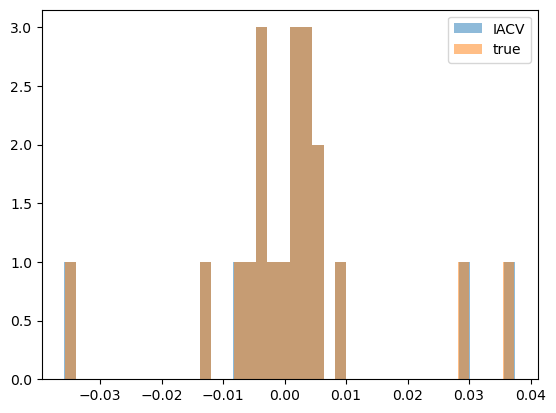

In [12]:
plt.hist(np.mean(clf.approx_cv_obj.iterates, axis=0), alpha=0.5, bins=40, label="IACV")
plt.hist(np.mean(clf.true_cv_obj.iterates, axis=0), alpha=0.5, bins=40, label="true")
plt.legend()

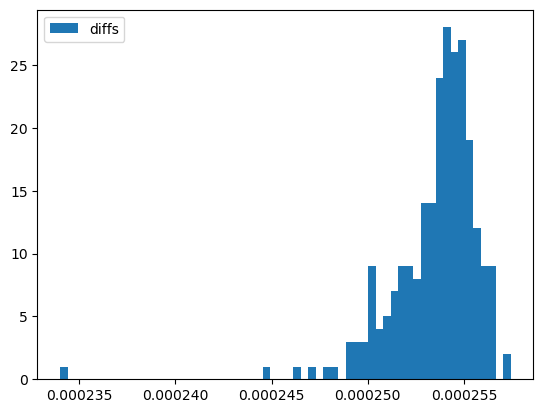

In [13]:
plt.hist(np.linalg.norm(clf.approx_cv_obj.iterates - clf.true_cv_obj.iterates, axis=1), bins=60, label="diffs")
plt.legend()

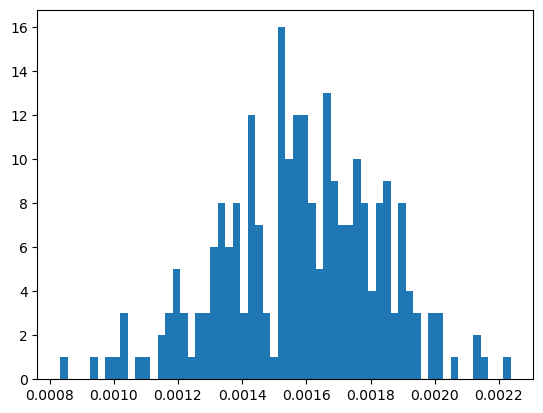

In [14]:
plt.hist(np.linalg.norm(clf.weights_ - clf.true_cv_obj.iterates, axis=1), bins=60, label="diffs")
plt.show()

In [15]:
iacv_mean = np.mean(clf.approx_cv_obj.iterates, axis=0)
coef = iacv_mean/np.linalg.norm(iacv_mean)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

diff 0.042987577617168427 | pct 0.015464148484170437


In [16]:
true_cv_mean = np.mean(clf.true_cv_obj.iterates, axis=0)
coef = true_cv_mean/np.linalg.norm(true_cv_mean)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

diff 0.04298883009211541 | pct 0.015464593547709465


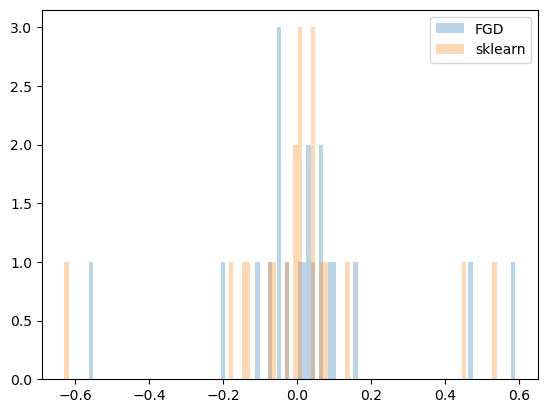

In [17]:
coef = clf.weights_/np.linalg.norm(clf.weights_)
nbin = 100
plt.hist(coef, bins=nbin, label="FGD", alpha=0.3)
plt.hist(sk_coef.flatten(), bins=nbin, label="sklearn", alpha=0.3)
plt.legend()
plt.show()

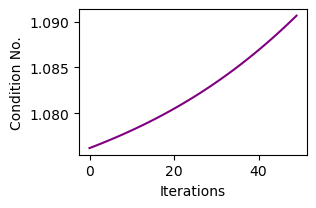

<Figure size 640x480 with 0 Axes>

In [18]:
fig, ax = plt.subplots()
#ax.plot(np.min(clf.approx_cv_obj.cond_nums, axis=1), label="Min Condition Number", c='b')
#ax.plot(np.max(clf.approx_cv_obj.cond_nums, axis=1), label="Max Condition Number", c='r')
ax.plot(np.mean(clf.approx_cv_obj.cond_nums, axis=1), label="Mean Condition Number", c='purple')
#ax.plot(clf.cond_num_bound_, label="Bound", c="black", linestyle="--")

#ax.set_yscale('log')
ax.set_xlabel("Iterations")
ax.set_ylabel("Condition No.")
ws = 1.95 # 1.75
hs = 1.85 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
#plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)
plt.show()
plt.savefig('svm_controlled_cond_no.pgf', bbox_inches='tight', pad_inches=0)

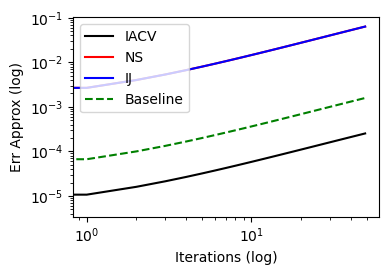

<Figure size 640x480 with 0 Axes>

In [19]:
fig, ax = plt.subplots()
ax.plot(clf.err_approx_["IACV"], label="IACV", c='black')
ax.plot(clf.err_approx_["NS"], label="NS", c='red')
ax.plot(clf.err_approx_["IJ"], label="IJ", c='blue')
ax.plot(clf.err_approx_["baseline"], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Iterations (log)")
ax.set_ylabel("Err Approx (log)")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svm_convergence_err_approx_comb.pgf', bbox_inches='tight', pad_inches=0)

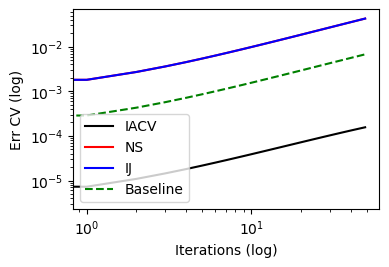

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ax = plt.subplots()
ax.plot(clf.err_cv_["IACV"], label="IACV", c='black')
ax.plot(clf.err_cv_["NS"], label="NS", c='red')
ax.plot(clf.err_cv_["IJ"], label="IJ", c='blue')
ax.plot(clf.err_cv_["baseline"], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Iterations (log)")
ax.set_ylabel("Err CV (log)")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svm_convergence_err_cv_comb.pgf', bbox_inches='tight', pad_inches=0)

In [34]:
# test different sigma values
import time
#sigmas = [2e-30, 2e-25, 2e-15, 2e-10, 2e-5, 2e-1]
#sigmas = [2e-15, 2e-10, 2e-5, 2e-3, 2e-1, 5e-1, 7e-1, 8e-1, 1, 1.25, 1.5, 2]
sigmas = [2e-15, 2e-12, 2e-10, 2e-8, 2e-5, 2e-3, 2e-1, 5e-1, 8e-1, 1]
last_err_approx = np.empty((len(sigmas), 2))
last_err_cv = np.empty((len(sigmas), 2))
cond_nums = np.empty(len(sigmas))

start = time.time()
for i, s in enumerate(sigmas):
    if s == 0:
        continue
    clf = SVM_smooth(sigma=s, lbd=0.5)
    #clf = SVM_smooth_kernel(sigma=s, lbd=1, kernel=RBF(2.5))
    print(f"running experiment for sigma = {s}")
    clf.fit(X_scaled, y, n_iter=1500, eta=0.5/n, approx_cv=True, cv=True, log_iacv=False, log_iter=False,
           save_err_cv=True, save_err_approx=True)
    y_pred = clf.predict(X_scaled)
    score = accuracy_score(y, y_pred)
    print(f"\tsigma {s} | score {score}")
    #print(clf.weights_)
    print(f"\tErr_Approx IACV: {clf.err_approx_['IACV'][-1]} | baseline: {clf.err_approx_['baseline'][-1]}" )
    print(f"\tErr_CV     IACV: {clf.err_cv_['IACV'][-1]} | baseline: {clf.err_cv_['baseline'][-1]}" )
    last_err_approx[i] = [clf.err_approx_["IACV"][-1], clf.err_approx_["baseline"][-1]]
    last_err_cv[i] = [clf.err_cv_["IACV"][-1], clf.err_cv_["baseline"][-1]]
    #cond_nums[i] = np.mean(clf.cond_nums_)

end = time.time()
print(end - start)

running experiment for sigma = 2e-15
	sigma 2e-15 | score 0.836
	Err_Approx IACV: 0.024775100871920586 | baseline: 0.02380314344144278
	Err_CV     IACV: 0.05565023049712181 | baseline: 0.089569590985775
running experiment for sigma = 2e-12
	sigma 2e-12 | score 0.836
	Err_Approx IACV: 0.024775100871920586 | baseline: 0.023803143441444793
	Err_CV     IACV: 0.05565023049712181 | baseline: 0.089569590985775
running experiment for sigma = 2e-10
	sigma 2e-10 | score 0.836
	Err_Approx IACV: 0.024775097146630287 | baseline: 0.02380314346149277
	Err_CV     IACV: 0.05565020814538002 | baseline: 0.089569590985775
running experiment for sigma = 2e-08
	sigma 2e-08 | score 0.836
	Err_Approx IACV: 0.024810252711176872 | baseline: 0.02380317819707202
	Err_CV     IACV: 0.05549117550253868 | baseline: 0.0895695611834526
running experiment for sigma = 2e-05
	sigma 2e-05 | score 0.836
	Err_Approx IACV: 0.022018924355506897 | baseline: 0.023802554397202576
	Err_CV     IACV: 0.04174203425645828 | baseline: 

In [35]:
last_err_cv = np.asarray(last_err_cv)
last_err_approx = np.asarray(last_err_approx)

last_err_cv = np.nan_to_num(last_err_cv, nan=1e2)
last_err_approx = np.nan_to_num(last_err_approx, nan=1e2)

last_err_cv = np.clip(last_err_cv, 0, 1e2)
last_err_approx = np.clip(last_err_approx, 0, 1e2)

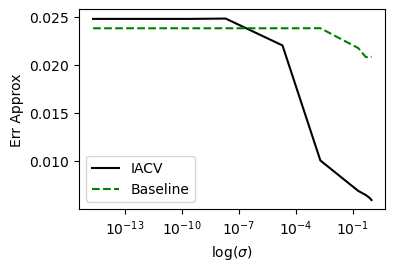

In [36]:
fig, ax = plt.subplots()
ax.plot(sigmas, last_err_approx[:, 0], label="IACV", c='black')
ax.plot(sigmas, last_err_approx[:, 1], label="Baseline", c='green', linestyle="--")
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel("$\log(\sigma)$")
ax.set_ylabel("Err Approx")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('kernel_svmtest_sigma_err_approx_mod.pgf', bbox_inches='tight', pad_inches=0)

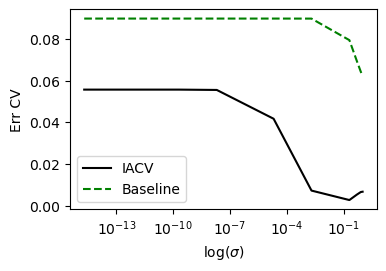

In [37]:
fig, ax = plt.subplots()
ax.plot(sigmas, last_err_cv[:, 0], label="IACV", c='black')
ax.plot(sigmas, last_err_cv[:, 1], label="Baseline", c='green', linestyle="--")
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel("$\log(\sigma)$")
ax.set_ylabel("Err CV")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('kernel_svmtest_sigma_err_cv_mod.pgf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
ax.plot(sigmas, cond_nums)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel("$\log(\sigma)$")
ax.set_ylabel("Condition Number")
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('svmtest_sigma_err_cv_mod.pgf', bbox_inches='tight', pad_inches=0)

In [ ]:
# test different lambda values
import time
#lambdas = np.linspace(0, 2.5, 12)
lambdas = np.linspace(0, 2.5, 4)
print(lambdas)
last_err_approx = []
last_err_cv = []
condition_nos = []
iacv_iterates = []
true_iterates = []

start = time.time()
for l in lambdas:
    #clf = SVM_smooth_kernel(sigma=0.25, lbd=l, kernel=RBF(2.5))
    #clf.fit(X_scaled, y, n_iter=1000, eta=0.5/n, approx_cv=True, cv=True,
    #        save_err_approx=True, save_err_cv=True, log_iacv=False, log_iter=False)
    print(f"running experiment for lambda = {l}")
    clf = SVM_smooth(sigma=1e-10, lbd=l)
    clf.fit(X_scaled, y, thresh=1e-7, n_iter=2000, eta=0.5/n, approx_cv=True, cv=True,
            save_err_approx=True, save_err_cv=True, save_cond_nums=True,
            log_iacv=False, log_iter=False, normalise=False, adjust_factor=True)
    y_pred = clf.predict(X_scaled)
    score = accuracy_score(y, y_pred)
    
    condition_nos.append(clf.approx_cv_obj.cond_nums)
    iacv_iterates.append(clf.approx_cv_obj.iterates)
    true_iterates.append(clf.true_cv_obj.iterates)

    #coef = clf.weights_/np.linalg.norm(clf.weights_)

    #print(clf.weights_)
    #print(f"\tlambda {l} | score {score} | grad {np.linalg.norm(clf.nabla_fgd_(clf.weights_, X_scaled, y, clf.sigma_, clf.lbd_))} | sklearn diff {np.mean(np.abs(coef- sk_coef))}")
    print(f"\tlambda {l} | score {score}")
    print(f"\tIACV: {clf.err_approx_['IACV'][-1]} | baseline: {clf.err_approx_['baseline'][-1]}" )
    last_err_approx.append([clf.err_approx_["IACV"][-1], clf.err_approx_["baseline"][-1]])
    last_err_cv.append([clf.err_cv_["IACV"][-1], clf.err_cv_["baseline"][-1]])

end = time.time()
print(end - start)

In [ ]:
last_err_approx = np.asarray(last_err_approx)
last_err_cv = np.asarray(last_err_cv)
condition_nos = np.asarray(condition_nos)
iacv_iterates = np.asarray(iacv_iterates)
true_iterates = np.asarray(true_iterates)

In [ ]:
fig, ax = plt.subplots()
ax.plot(lambdas, last_err_approx[:, 0], label="IACV", c='black')
ax.plot(lambdas, last_err_approx[:, 1], label="Baseline", c='green', linestyle="--")
#ax.set_yscale('log')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Err Approx")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('kernel_svmtest_lambda_err_approx_mod.pgf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
ax.plot(lambdas, last_err_cv[:, 0], label="IACV", c='black')
ax.plot(lambdas, last_err_cv[:, 1], label="Baseline", c='green', linestyle="--")
#ax.set_yscale('log')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Err CV")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('kernel_svmtest_lambda_err_cv_mod.pgf', bbox_inches='tight', pad_inches=0)

In [ ]:
mean_cond = np.mean(np.mean(condition_nos, axis=1), axis=1)
mean_cond.shape

In [ ]:
fig, ax = plt.subplots()
ax.plot(lambdas, mean_cond)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Mean Condition Number")
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svmtest_lambda_cond_no_mod.pgf', bbox_inches='tight', pad_inches=0)

## fig, ax = plt.subplots()
start = 0
ax.plot(lambdas[start:], iacv_means[start:], label="IACV")
ax.plot(lambdas[start:], true_means[start:], label="true", linestyle="--")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Mean of CV Iterates")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('svmtest_lambda_coef_mod.pgf', bbox_inches='tight', pad_inches=0)